In [544]:
# --- Bibliotecas Padrão ---
import os

# --- Manipulação de Dados e Matemática ---
import pandas as pd
import numpy as np

# --- Visualização de Dados ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Pré-processamento e Seleção de Modelos ---
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# --- Modelos de Machine Learning ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# --- Métricas de Avaliação ---
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    balanced_accuracy_score, 
    roc_auc_score
)

In [545]:
# ==============================================================================
# CONFIGURAÇÃO E MAPEAMENTO
# ==============================================================================
DATA_PATH = os.path.join('..', 'data', 'BASE DE DADOS PEDE 2024 - DATATHON.xlsx')

base_mapping = {
    'RA': 'RA', 'Fase': 'FASE', 'Gênero': 'GENERO', 'Ano ingresso': 'ANO_INGRESSO',
    'IAA': 'IAA', 'IEG': 'IEG', 'IPS': 'IPS', 'IDA': 'IDA', 'IPV': 'IPV', 'IAN': 'IAN'
}

mapa_2022 = base_mapping.copy()
mapa_2022.update({
    'Idade 22': 'IDADE', 'Matem': 'NOTA_MAT', 'Portug': 'NOTA_PORT', 'Inglês': 'NOTA_ING',
    'Fase ideal': 'FASE_IDEAL', 'Defas': 'DEFASAGEM', 'Pedra 22': 'PEDRA'
})

mapa_2023 = base_mapping.copy()
mapa_2023.update({
    'Idade': 'IDADE', 'Mat': 'NOTA_MAT', 'Por': 'NOTA_PORT', 'Ing': 'NOTA_ING',
    'Fase Ideal': 'FASE_IDEAL', 'Defasagem': 'DEFASAGEM', 'IPP': 'IPP', 'Pedra 2023': 'PEDRA'
})

mapa_2024 = base_mapping.copy()
mapa_2024.update({
    'Idade': 'IDADE', 'Mat': 'NOTA_MAT', 'Por': 'NOTA_PORT', 'Ing': 'NOTA_ING',
    'Fase Ideal': 'FASE_IDEAL', 'Defasagem': 'DEFASAGEM', 'IPP': 'IPP', 'Pedra 2024': 'PEDRA'
})

YEAR_CONFIG = {
    '2022': mapa_2022,
    '2023': mapa_2023,
    '2024': mapa_2024
}

FINAL_COL_ORDER = [
    'ANO_DATATHON', 'RA', 'FASE', 'GENERO', 'IDADE', 'ANO_INGRESSO',
    'IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IAN', 'IPP',
    'NOTA_MAT', 'NOTA_PORT', 'NOTA_ING', 'FASE_IDEAL', 'DEFASAGEM', 'PEDRA'
]

# ==============================================================================
# ETL
# ==============================================================================
try:
    print(f"Lendo arquivo: {DATA_PATH}")
    dict_abas = pd.read_excel(DATA_PATH, sheet_name=None)
except FileNotFoundError:
    raise FileNotFoundError(f"Arquivo não encontrado em: {DATA_PATH}")

dfs_para_unir = []

for sheet_name, df_raw in dict_abas.items():
    year_key = next((y for y in YEAR_CONFIG.keys() if y in sheet_name), None)
    
    if not year_key:
        print(f"Skipping sheet: {sheet_name} (No valid year found)")
        continue

    print(f"Processando: '{sheet_name}' -> Ano {year_key}")
    current_map = YEAR_CONFIG[year_key]
    
    df_clean = df_raw.loc[:, ~df_raw.columns.duplicated()].copy()
    
    valid_cols = [c for c in current_map.keys() if c in df_clean.columns]
    df_clean = df_clean[valid_cols].rename(columns=current_map)
    
    df_clean['ANO_DATATHON'] = int(year_key)
    
    if 'IPP' not in df_clean.columns:
        df_clean['IPP'] = np.nan

    dfs_para_unir.append(df_clean)

# ==============================================================================
# CONSOLIDAÇÃO
# ==============================================================================
if dfs_para_unir:
    df_final = pd.concat(dfs_para_unir, ignore_index=True, sort=False)
    
    cols_existentes = [c for c in FINAL_COL_ORDER if c in df_final.columns]
    df_final = df_final[cols_existentes]

    print(f"\nDataset Consolidado: {df_final.shape[0]} linhas, {df_final.shape[1]} colunas.")
    display(df_final.head())
else:
    raise ValueError("Nenhum dado processado. Verifique os nomes das abas.")

Lendo arquivo: ..\data\BASE DE DADOS PEDE 2024 - DATATHON.xlsx
Processando: 'PEDE2022' -> Ano 2022
Processando: 'PEDE2023' -> Ano 2023
Processando: 'PEDE2024' -> Ano 2024

Dataset Consolidado: 3030 linhas, 19 colunas.


,ANO_DATATHON,RA,FASE,GENERO,IDADE,ANO_INGRESSO,IAA,IEG,IPS,IDA,IPV,IAN,IPP,NOTA_MAT,NOTA_PORT,NOTA_ING,FASE_IDEAL,DEFASAGEM,PEDRA
0,2022,RA-1,7,Menina,19,2016,8.3,4.1,5.6,4.0,7.278,5.0,NaN,2.7,3.5,6.0,Fase 8 (Universitários),-1,Quartzo
1,2022,RA-2,7,Menina,17,2017,8.8,5.2,6.3,6.8,6.778,10.0,NaN,6.3,4.5,9.7,Fase 7 (3º EM),0,Ametista
2,2022,RA-3,7,Menina,17,2016,0.0,7.9,5.6,5.6,7.556,10.0,NaN,5.8,4.0,6.9,Fase 7 (3º EM),0,Ágata
3,2022,RA-4,7,Menino,17,2017,8.8,4.5,5.6,5.0,5.278,10.0,NaN,2.8,3.5,8.7,Fase 7 (3º EM),0,Quartzo
4,2022,RA-5,7,Menina,17,2016,7.9,8.6,5.6,5.2,7.389,10.0,NaN,7.0,2.9,5.7,Fase 7 (3º EM),0,Ametista


In [546]:
# ==============================================================================
# ANÁLISE EXPLORATÓRIA PRELIMINAR (DIAGNÓSTICO DE DADOS)
# ==============================================================================

print(f"Dimensões do Dataset: {df_final.shape}")
df_final.info()

summary_df = pd.DataFrame({
    'Tipo': df_final.dtypes,
    'Card. (Únicos)': df_final.nunique(),
    'Nulos (Qtd)': df_final.isnull().sum(),
    'Nulos (%)': (df_final.isnull().mean() * 100).round(2)
}).sort_values(by='Nulos (%)', ascending=False)

print("\n--- Diagnóstico de Qualidade das Variáveis ---")
display(summary_df)

Dimensões do Dataset: (3030, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3030 entries, 0 to 3029
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ANO_DATATHON  3030 non-null   int64  
 1   RA            3030 non-null   object 
 2   FASE          3030 non-null   object 
 3   GENERO        3030 non-null   object 
 4   IDADE         3030 non-null   object 
 5   ANO_INGRESSO  3030 non-null   int64  
 6   IAA           2865 non-null   float64
 7   IEG           2954 non-null   float64
 8   IPS           2859 non-null   float64
 9   IDA           2852 non-null   float64
 10  IPV           2852 non-null   float64
 11  IAN           3030 non-null   float64
 12  IPP           1992 non-null   float64
 13  NOTA_MAT      2846 non-null   float64
 14  NOTA_PORT     2845 non-null   float64
 15  NOTA_ING      1091 non-null   float64
 16  FASE_IDEAL    3030 non-null   object 
 17  DEFASAGEM     3030 non-null   int64  


,Tipo,Card. (Únicos),Nulos (Qtd),Nulos (%)
NOTA_ING,float64,84,1939,63.99
IPP,float64,86,1038,34.26
NOTA_PORT,float64,87,185,6.11
NOTA_MAT,float64,83,184,6.07
IDA,float64,163,178,5.87
IPV,float64,920,178,5.87
IPS,float64,57,171,5.64
IAA,float64,70,165,5.45
PEDRA,object,6,147,4.85
IEG,float64,804,76,2.51


# 📚 Dicionário de Dados - Passos Mágicos

Este documento descreve as variáveis presentes no dataset unificado (`PEDE_PASSOS_DATASET_LIMPO.csv`), consolidando os dados de 2022, 2023 e 2024.

---

### 1. Identificação e Controle
Variáveis utilizadas para rastreabilidade e organização temporal dos registros.

* **`ANO_DATATHON`**: Ano de referência do registro (Safra). Indica se o dado pertence ao ciclo de 2022, 2023 ou 2024.
* **`RA`**: Registro Acadêmico. Identificador único e anonimizado do aluno. Permite acompanhar a evolução do mesmo estudante ao longo dos anos.

### 2. Perfil Demográfico e Escolar
Características individuais e educacionais do aluno.

* **`GENERO`**: Sexo do aluno.
* **`IDADE`**: Idade do aluno no ano de referência.
* **`ANO_INGRESSO`**: Ano em que o aluno iniciou sua trajetória na Associação Passos Mágicos.
* **`FASE`**: Turma ou etapa atual em que o aluno está matriculado na ONG (ex: Fase 1, Alpha).
* **`FASE_IDEAL`**: A fase em que o aluno *deveria* estar, considerando sua idade ou ano escolar regular.
* **`DEFASAGEM`**: Diferença entre a `FASE` atual e a `FASE_IDEAL`. Valores negativos indicam atraso escolar.

### 3. Indicadores Psicossociais (Soft Skills)
Métricas que compõem a dimensão psicossocial e comportamental do INDE (Índice de Desenvolvimento Educacional).

* **`IAA` (Índice de Autoavaliação)**: Nota atribuída pelo próprio aluno sobre seu desempenho, sentimentos e autoconfiança.
* **`IEG` (Índice de Engajamento)**: Mede o comprometimento com as atividades (entrega de lições, presença, participação).
* **`IPS` (Índice Psicossocial)**: Avaliação realizada por psicólogos sobre aspectos emocionais, sociais e familiares.
* **`IPV` (Índice de Ponto de Virada)**: Avalia o potencial de transformação social e a resiliência do aluno frente a vulnerabilidades.
* **`IAN` (Indicador de Adequação de Nível)**: Mede o grau de adequação do conhecimento do aluno em relação ao esperado para sua fase.
* **`IPP` (Índice Psicopedagógico)**: Avaliação de aspectos de aprendizagem e possíveis dificuldades cognitivas. *(Nota: Este indicador não foi coletado em 2022, apresentando valores nulos nesse ano).*

### 4. Desempenho Acadêmico (Hard Skills)
Notas e indicadores de performance escolar.

* **`IDA` (Índice de Aprendizagem)**: Indicador consolidado de desempenho escolar (média ponderada das matérias).
* **`NOTA_MAT`**: Nota de Matemática.
* **`NOTA_PORT`**: Nota de Português.
* **`NOTA_ING`**: Nota de Inglês.

### 5. Variável Alvo (Target)
A classificação final do aluno, que determina a renovação de bolsas e benefícios.

* **`PEDRA`**: Classificação baseada no INDE Geral do aluno.
    * 💎 **Quartzo**: Nível Inicial / Atenção.
    * 💎 **Ágata**: Nível Básico / Em desenvolvimento.
    * 💎 **Ametista**: Nível Intermediário / Bom desempenho.
    * 💎 **Topázio**: Nível Avançado / Excelente desempenho.

In [547]:
# ==============================================================================
# PADRONIZAÇÃO E FILTRAGEM DE TARGET (PEDRAS)
# ==============================================================================
CORRECOES_PEDRA = {'Agata': 'Ágata'}
TARGET_CLASSES = ['Ágata', 'Quartzo', 'Topázio', 'Ametista']

df_final['PEDRA'] = df_final['PEDRA'].astype(str).str.strip().replace(CORRECOES_PEDRA)

mask_validas = df_final['PEDRA'].isin(TARGET_CLASSES)
valores_descartados = df_final.loc[~mask_validas, 'PEDRA'].unique()
qtd_descartada = (~mask_validas).sum()

print(f"Classes descartadas (Ruído/Outliers): {valores_descartados}")
print(f"Registros removidos: {qtd_descartada} ({(qtd_descartada/len(df_final)*100):.2f}% do total original)")

df_final = df_final[mask_validas].copy()

print(f"\nDataset Validado: {df_final.shape[0]} amostras.")

Classes descartadas (Ruído/Outliers): ['nan' 'INCLUIR']
Registros removidos: 185 (6.11% do total original)

Dataset Validado: 2845 amostras.


--- Visão Geral do Dataset ---
Shape: (2845, 19)


,ANO_DATATHON,RA,FASE,GENERO,IDADE,ANO_INGRESSO,IAA,IEG,IPS,IDA,IPV,IAN,IPP,NOTA_MAT,NOTA_PORT,NOTA_ING,FASE_IDEAL,DEFASAGEM,PEDRA
0,2022,RA-1,7,Menina,19,2016,8.3,4.1,5.6,4.0,7.278,5.0,NaN,2.7,3.5,6.0,Fase 8 (Universitários),-1,Quartzo
1,2022,RA-2,7,Menina,17,2017,8.8,5.2,6.3,6.8,6.778,10.0,NaN,6.3,4.5,9.7,Fase 7 (3º EM),0,Ametista
2,2022,RA-3,7,Menina,17,2016,0.0,7.9,5.6,5.6,7.556,10.0,NaN,5.8,4.0,6.9,Fase 7 (3º EM),0,Ágata
3,2022,RA-4,7,Menino,17,2017,8.8,4.5,5.6,5.0,5.278,10.0,NaN,2.8,3.5,8.7,Fase 7 (3º EM),0,Quartzo
4,2022,RA-5,7,Menina,17,2016,7.9,8.6,5.6,5.2,7.389,10.0,NaN,7.0,2.9,5.7,Fase 7 (3º EM),0,Ametista


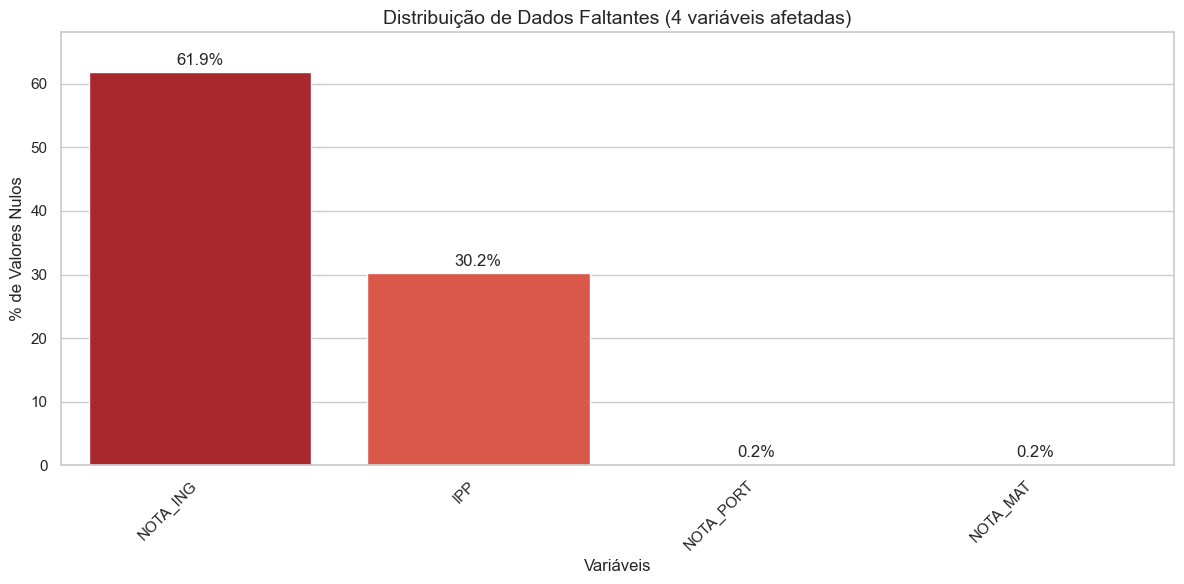


[ATENÇÃO] Variáveis com >20.0% de nulos (Candidatas a Drop):
['NOTA_ING', 'IPP']


In [548]:
# ==============================================================================
# ANÁLISE VISUAL DE DADOS FALTANTES (MISSING VALUES)
# ==============================================================================

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("--- Visão Geral do Dataset ---")
print(f"Shape: {df_final.shape}")
display(df_final.head())

missing_series = df_final.isnull().mean().mul(100).sort_values(ascending=False)
missing_series = missing_series[missing_series > 0]

if not missing_series.empty:
    plt.figure(figsize=(12, 6))
    
    ax = sns.barplot(
        x=missing_series.index, 
        y=missing_series.values, 
        hue=missing_series.index,
        legend=False, 
        palette="Reds_r"
    )
    
    plt.title(f"Distribuição de Dados Faltantes ({len(missing_series)} variáveis afetadas)", fontsize=14)
    plt.ylabel("% de Valores Nulos")
    plt.xlabel("Variáveis")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, missing_series.max() * 1.1)
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', padding=3)
        
    plt.tight_layout()
    plt.show()
    
    THRESHOLD = 20.0
    cols_criticas = missing_series[missing_series > THRESHOLD].index.tolist()
    
    if cols_criticas:
        print(f"\n[ATENÇÃO] Variáveis com >{THRESHOLD}% de nulos (Candidatas a Drop):")
        print(cols_criticas)
    else:
        print(f"\n[OK] Nenhuma variável ultrapassa o limite crítico de {THRESHOLD}% de nulos.")
        
else:
    print("\n[SUCESSO] Dataset completo. Nenhum valor nulo encontrado.")

In [549]:
# ==============================================================================
# TRATAMENTO DE VALORES NULOS E FEATURE ENGINEERING
# ==============================================================================

imputation_stats = {}

df_final['IPP_COLETADO'] = df_final['IPP'].notnull().astype(int)
ipp_median = df_final['IPP'].median()
df_final['IPP'] = df_final['IPP'].fillna(ipp_median)
imputation_stats['IPP_MEDIANA'] = ipp_median

df_final['TEM_INGLES'] = df_final['NOTA_ING'].notnull().astype(int)
df_final['NOTA_ING'] = df_final['NOTA_ING'].fillna(0)

core_subjects = ['NOTA_MAT', 'NOTA_PORT']
for col in core_subjects:
    median_val = df_final[col].median()
    df_final[col] = df_final[col].fillna(median_val)
    imputation_stats[f'{col}_MEDIANA'] = median_val

df_final.drop(columns=['IDA'], errors='ignore', inplace=True)

print("Estatísticas de Imputação Registradas:", imputation_stats)
print("\nVerificação de Integridade (Nulos Remanescentes):")
cols_check = ['IPP', 'NOTA_ING', 'NOTA_MAT', 'NOTA_PORT', 'IPP_COLETADO', 'TEM_INGLES']
print(df_final[cols_check].isnull().sum())

Estatísticas de Imputação Registradas: {'IPP_MEDIANA': 7.5, 'NOTA_MAT_MEDIANA': 6.3, 'NOTA_PORT_MEDIANA': 6.7}

Verificação de Integridade (Nulos Remanescentes):
IPP             0
NOTA_ING        0
NOTA_MAT        0
NOTA_PORT       0
IPP_COLETADO    0
TEM_INGLES      0
dtype: int64


In [550]:
# ==============================================================================
# INSPEÇÃO DIAGNÓSTICA: VARIÁVEL 'IDADE'
# ==============================================================================

print("--- Valores Únicos em IDADE (Visualização como String) ---")
unicos_ordenados = sorted(df_final['IDADE'].astype(str).unique())
print(unicos_ordenados)

print("\n--- Contagem de Ocorrências (Top 20) ---")
print(df_final['IDADE'].value_counts().head(20))

--- Valores Únicos em IDADE (Visualização como String) ---
['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1900-01-07 00:00:00', '1900-01-08 00:00:00', '1900-01-09 00:00:00', '1900-01-10 00:00:00', '1900-01-11 00:00:00', '1900-01-12 00:00:00', '1900-01-13 00:00:00', '1900-01-14 00:00:00', '1900-01-15 00:00:00', '1900-01-16 00:00:00', '1900-01-17 00:00:00', '1900-01-18 00:00:00', '1900-01-19 00:00:00', '1900-01-20 00:00:00', '20', '21', '22', '7', '8', '9']

--- Contagem de Ocorrências (Top 20) ---
IDADE
10                     321
12                     316
11                     311
13                     268
9                      263
14                     235
15                     198
8                      180
16                     164
17                     129
1900-01-11 00:00:00     56
7                       47
1900-01-12 00:00:00     47
1900-01-09 00:00:00     43
1900-01-14 00:00:00     42
1900-01-10 00:00:00     36
18                      34
1900-01-08 00:00:0

In [551]:
# ==============================================================================
# CORREÇÃO E PADRONIZAÇÃO DA VARIÁVEL 'IDADE'
# ==============================================================================

df_final['IDADE'] = df_final['IDADE'].astype(str)

mask_excel_dates = df_final['IDADE'].str.startswith('1900-')

if mask_excel_dates.any():
    print(f"Detectada serialização de data incorreta em {mask_excel_dates.sum()} registros. Corrigindo...")
    df_final.loc[mask_excel_dates, 'IDADE'] = pd.to_datetime(
        df_final.loc[mask_excel_dates, 'IDADE'], errors='coerce'
    ).dt.day

df_final['IDADE'] = pd.to_numeric(df_final['IDADE'], errors='coerce')

median_age = df_final['IDADE'].median()
df_final['IDADE'] = df_final['IDADE'].fillna(median_age)

df_final['IDADE'] = df_final['IDADE'].astype(int)

print("\nDistribuição de Idades (Pós-Tratamento):")
print(sorted(df_final['IDADE'].unique()))
print(f"Nulos restantes: {df_final['IDADE'].isnull().sum()}")

Detectada serialização de data incorreta em 367 registros. Corrigindo...

Distribuição de Idades (Pós-Tratamento):
[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
Nulos restantes: 0


In [552]:
# ==============================================================================
# ENCODING DE VARIÁVEIS CATEGÓRICAS E LIMPEZA DE FORMATO
# ==============================================================================

TARGET_MAP = {'Quartzo': 0, 'Ágata': 1, 'Ametista': 2, 'Topázio': 3}
GENDER_MAP = {'Feminino': 1, 'Menina': 1, 'Masculino': 0, 'Menino': 0}

df_final['PEDRA'] = df_final['PEDRA'].astype(str).str.strip().map(TARGET_MAP)

df_final['GENERO'] = df_final['GENERO'].astype(str).str.strip().map(GENDER_MAP)

cols_fase = ['FASE', 'FASE_IDEAL']

for col in cols_fase:
    df_final[col] = df_final[col].astype(str).str.extract(r'(\d+)', expand=False)
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce').fillna(0).astype(int)

df_final['RA'] = df_final['RA'].astype(str).str.replace(r'\D', '', regex=True)
df_final['RA'] = pd.to_numeric(df_final['RA'], errors='coerce')

cols_check = ['PEDRA', 'GENERO', 'FASE', 'FASE_IDEAL', 'RA']

print("--- Amostra Pós-Processamento ---")
display(df_final[cols_check].head())

print("\n--- Verificação de Tipos e Nulos ---")
info_check = pd.DataFrame({
    'Dtype': df_final[cols_check].dtypes,
    'Nulos': df_final[cols_check].isnull().sum()
})
display(info_check)

--- Amostra Pós-Processamento ---


,PEDRA,GENERO,FASE,FASE_IDEAL,RA
0,0,1,7,8,1
1,2,1,7,7,2
2,1,1,7,7,3
3,0,0,7,7,4
4,2,1,7,7,5



--- Verificação de Tipos e Nulos ---


,Dtype,Nulos
PEDRA,int64,0
GENERO,int64,0
FASE,int32,0
FASE_IDEAL,int32,0
RA,int64,0


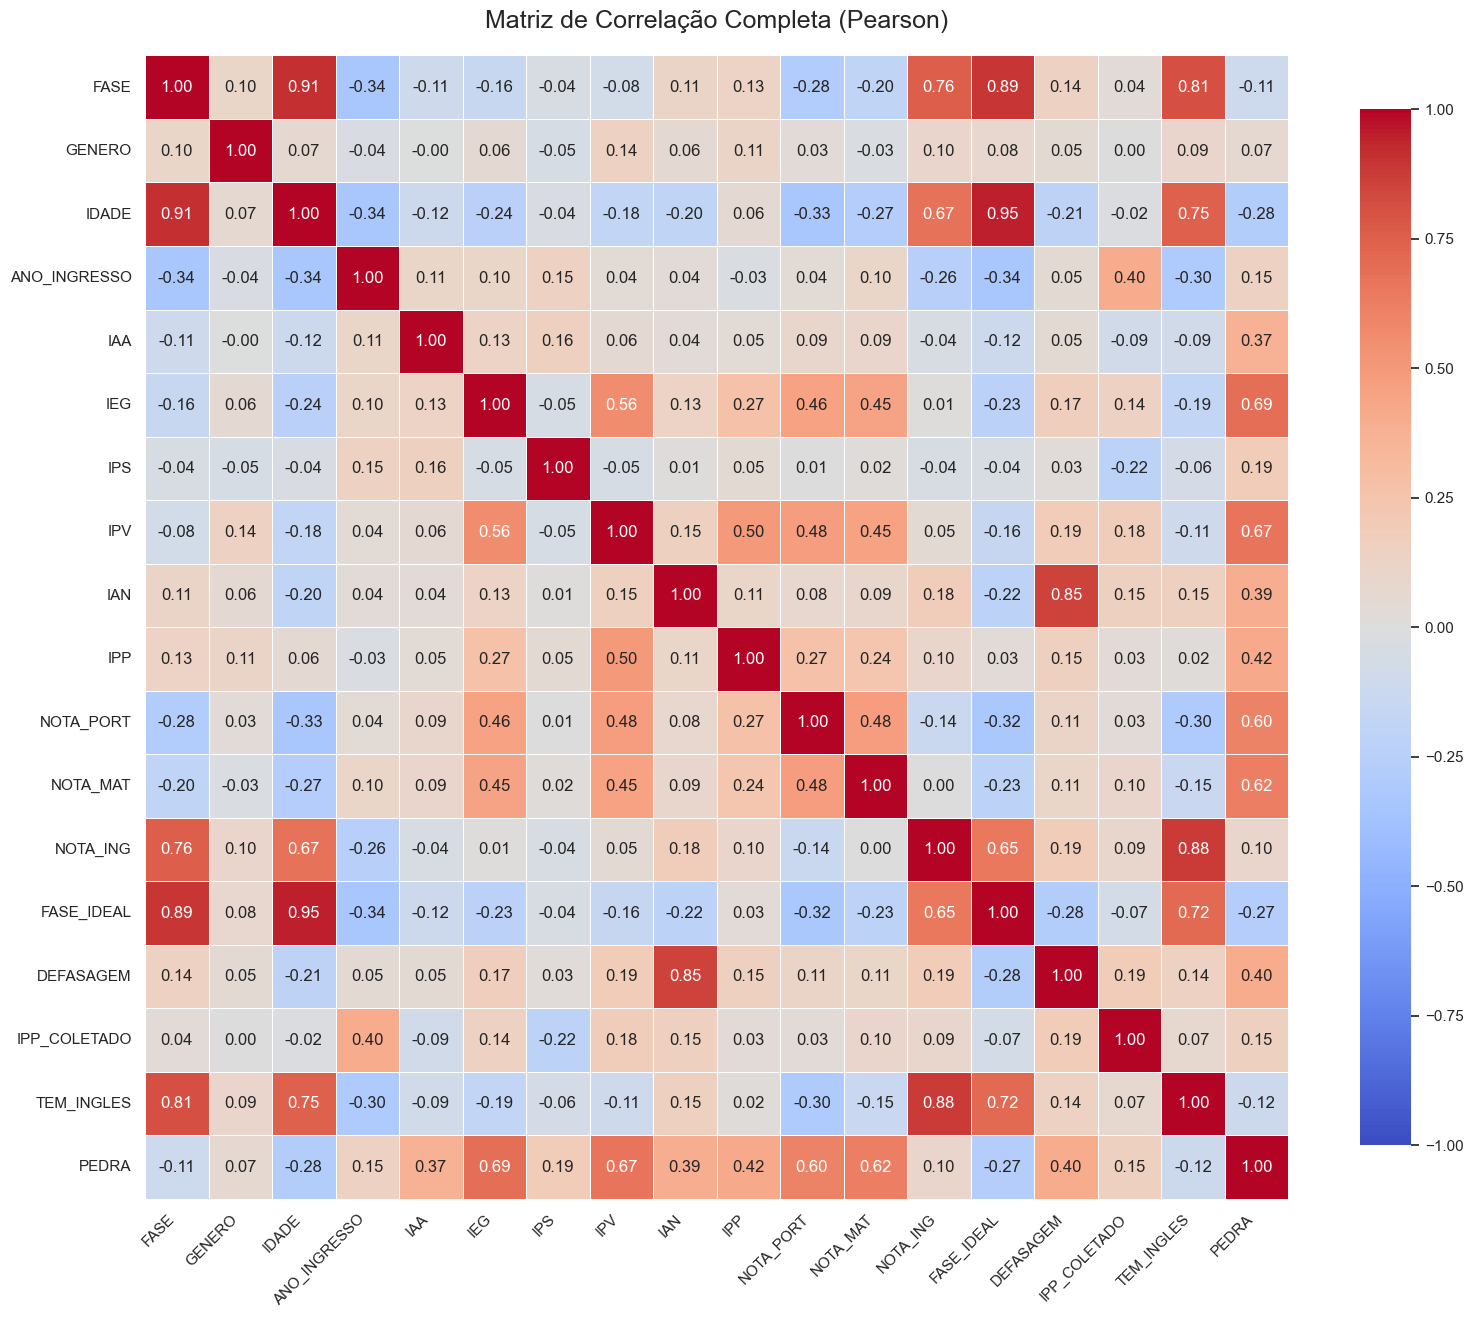


--- Drivers de Correlação com 'PEDRA' (Ordenado) ---
IEG             0.694958
IPV             0.666839
NOTA_MAT        0.619980
NOTA_PORT       0.603866
IPP             0.417965
DEFASAGEM       0.402304
IAN             0.392179
IAA             0.374667
IPS             0.190742
IPP_COLETADO    0.148877
ANO_INGRESSO    0.148048
NOTA_ING        0.095743
GENERO          0.069702
FASE           -0.110629
TEM_INGLES     -0.118968
FASE_IDEAL     -0.272162
IDADE          -0.280900
Name: PEDRA, dtype: float64


In [553]:
# ==============================================================================
# ANÁLISE DE CORRELAÇÃO (VISÃO COMPLETA)
# ==============================================================================

FEATURES_ANALISE = [
    'FASE', 'GENERO', 'IDADE', 'ANO_INGRESSO',
    'IAA', 'IEG', 'IPS', 'IPV', 'IAN', 'IPP',
    'NOTA_PORT', 'NOTA_MAT', 'NOTA_ING',
    'FASE_IDEAL', 'DEFASAGEM', 'IPP_COLETADO',
    'TEM_INGLES', 'PEDRA'
]

cols_validas = [c for c in FEATURES_ANALISE if c in df_final.columns]

corr_matrix = df_final[cols_validas].corr(numeric_only=True)

plt.figure(figsize=(16, 14))
plt.title("Matriz de Correlação Completa (Pearson)", fontsize=18, pad=20)

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1, vmax=1,
    center=0,
    linewidths=0.5,
    square=True, 
    cbar_kws={"shrink": 0.8}
)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

if 'PEDRA' in corr_matrix.columns:
    print("\n--- Drivers de Correlação com 'PEDRA' (Ordenado) ---")
    print(corr_matrix['PEDRA'].drop('PEDRA').sort_values(ascending=False))

In [554]:
# ==============================================================================
# SELEÇÃO DE FEATURES (REMOÇÃO DE MULTICOLINEARIDADE)
# ==============================================================================

FEATURES_REDUNDANTES = ['FASE_IDEAL']

cols_drop = [c for c in FEATURES_REDUNDANTES if c in df_final.columns]

if cols_drop:
    df_final.drop(columns=cols_drop, inplace=True)
    print(f"Features removidas (Alta Colinearidade): {cols_drop}")
    print(f"Motivo: Informação redundante já capturada pela variável 'IDADE'.")
else:
    print("Nenhuma feature redundante encontrada para remoção (já processado).")

print(f"\nShape atual do Dataset: {df_final.shape}")

Features removidas (Alta Colinearidade): ['FASE_IDEAL']
Motivo: Informação redundante já capturada pela variável 'IDADE'.

Shape atual do Dataset: (2845, 19)


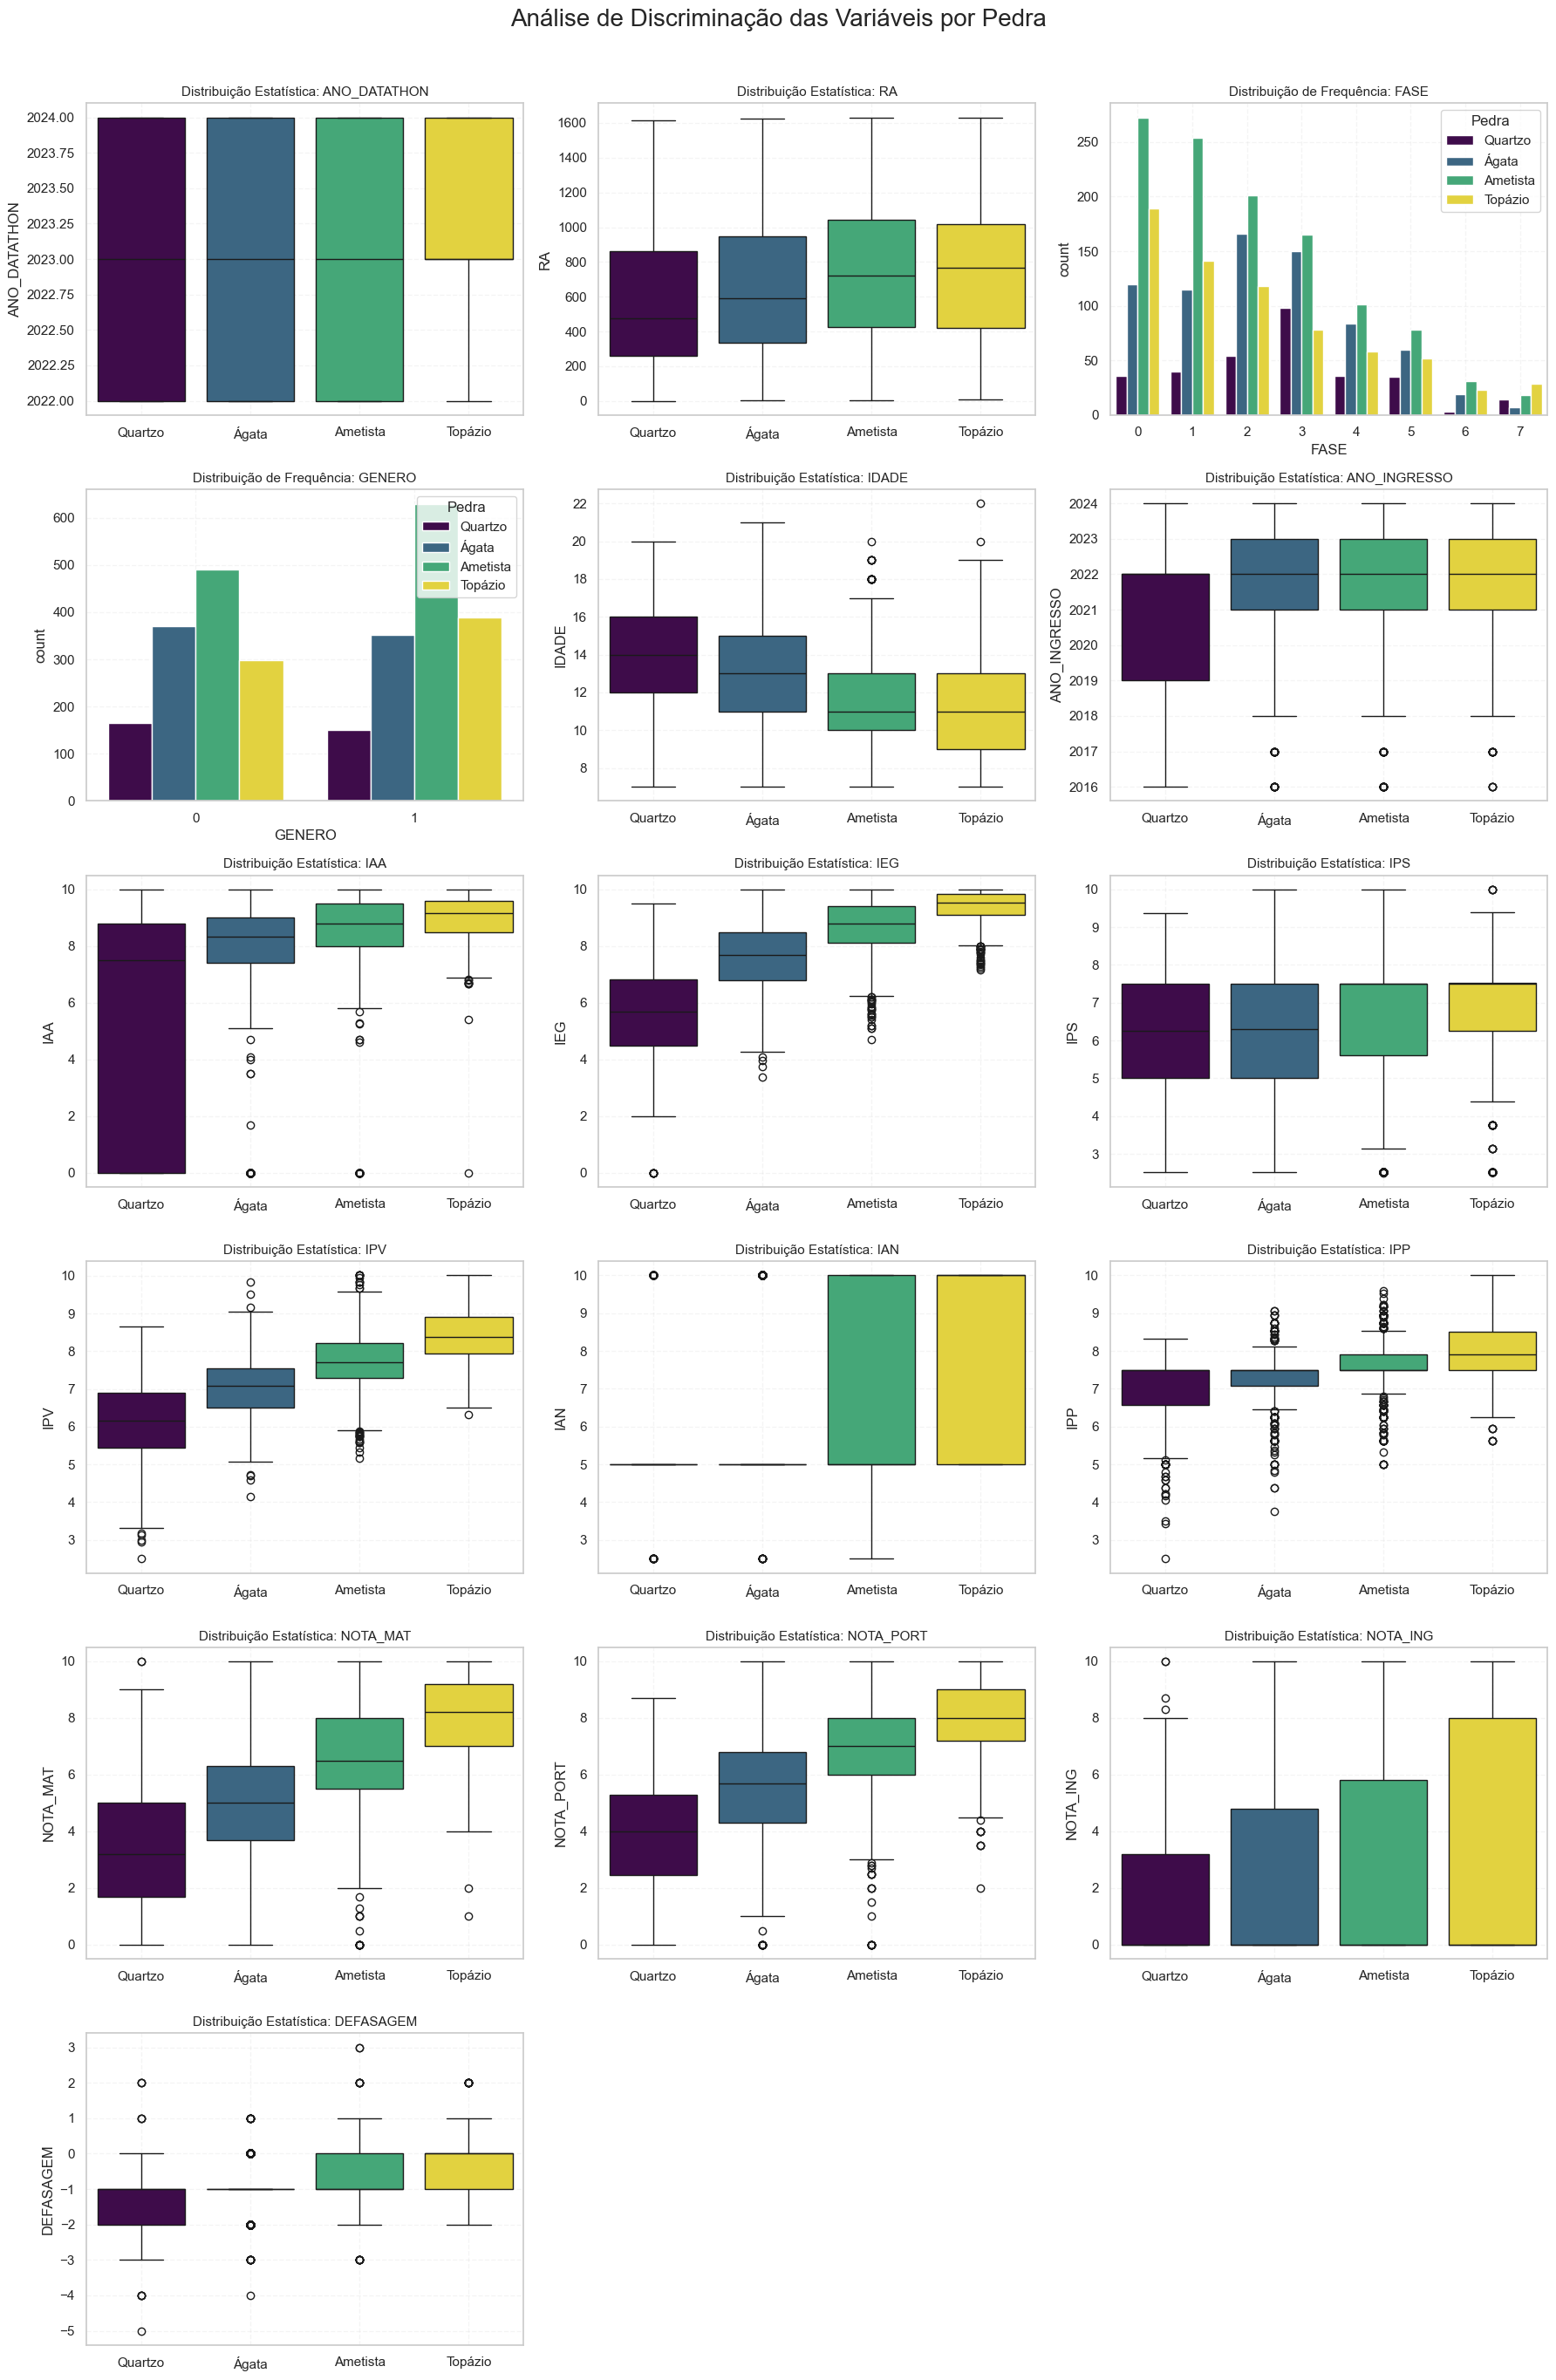

In [555]:
# ==============================================================================
# ANÁLISE BIVARIADA: VISUALIZAÇÃO DE DISTRIBUIÇÕES POR CLASSE (PEDRA)
# ==============================================================================
import math

COLS_CATEGORICAS = ['GENERO', 'TEM_INGLES', 'IPP_COLETADO', 'FASE']

features_plot = [c for c in cols_existentes if c in df_final.columns and c != 'PEDRA']

n_cols = 3
n_rows = math.ceil(len(features_plot) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4.5))
axes = axes.flatten() # Vetoriza a matriz de eixos para facilitar iteração

LABEL_MAP = {0: 'Quartzo', 1: 'Ágata', 2: 'Ametista', 3: 'Topázio'}

plt.suptitle("Análise de Discriminação das Variáveis por Pedra", fontsize=20, y=1.01)

for i, col in enumerate(features_plot):
    ax = axes[i]
    
    if col in COLS_CATEGORICAS:
        sns.countplot(data=df_final, x=col, hue='PEDRA', palette='viridis', ax=ax)
        ax.set_title(f"Distribuição de Frequência: {col}", fontsize=11)
        
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [LABEL_MAP.get(int(float(l)), l) for l in labels]
        ax.legend(handles, new_labels, title='Pedra', loc='upper right')
        
    else:
        sns.boxplot(data=df_final, x='PEDRA', y=col, palette='viridis', hue='PEDRA', legend=False, ax=ax)
        ax.set_title(f"Distribuição Estatística: {col}", fontsize=11)
        
        current_ticks = ax.get_xticks()
        ax.set_xticklabels([LABEL_MAP.get(int(t), t) for t in current_ticks])
        ax.set_xlabel("")

    ax.grid(True, alpha=0.2, linestyle='--')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

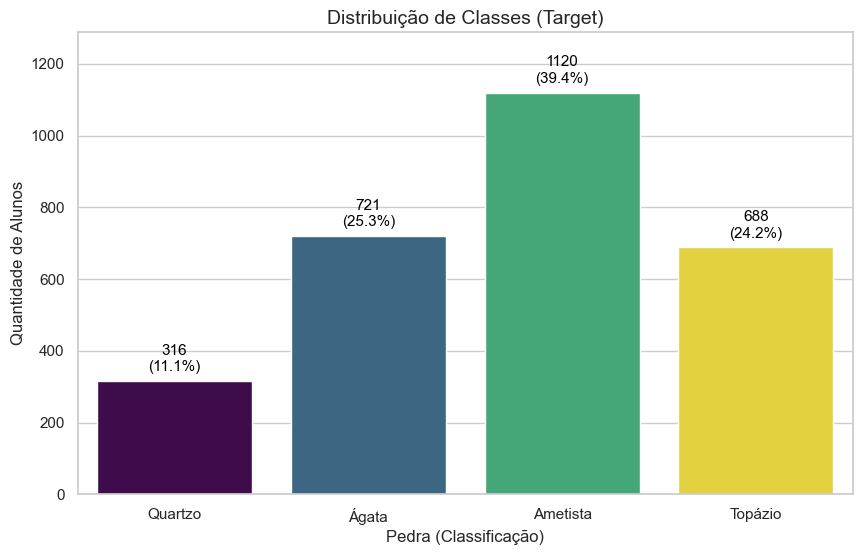

--- Diagnóstico de Desbalanceamento ---
Classe Majoritária: 39.37% dos dados.
Classe Minoritária: 11.11% dos dados.
Baseline (Chute Cego): Se o modelo chutar sempre a classe maior, acerta 39.37%.
[ATENÇÃO] Desbalanceamento moderado. Avalie métricas como F1-Score em vez de Acurácia.


In [556]:
# ==============================================================================
# ANÁLISE DA VARIÁVEL ALVO (DIAGNÓSTICO DE BALANCEAMENTO)
# ==============================================================================

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_final, x='PEDRA', palette='viridis', hue='PEDRA', legend=False)

LABELS_PEDRA = {0: 'Quartzo', 1: 'Ágata', 2: 'Ametista', 3: 'Topázio'}
nomes_x = [LABELS_PEDRA.get(int(x), x) for x in sorted(df_final['PEDRA'].unique())]
ax.set_xticklabels(nomes_x)

plt.title('Distribuição de Classes (Target)', fontsize=14)
plt.xlabel('Pedra (Classificação)')
plt.ylabel('Quantidade de Alunos')

total = len(df_final)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{int(height)}\n({percentage:.1f}%)', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=11, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.ylim(0, df_final['PEDRA'].value_counts().max() * 1.15)
plt.show()

counts = df_final['PEDRA'].value_counts(normalize=True)
majoritaria = counts.max() * 100
minoritaria = counts.min() * 100

print(f"--- Diagnóstico de Desbalanceamento ---")
print(f"Classe Majoritária: {majoritaria:.2f}% dos dados.")
print(f"Classe Minoritária: {minoritaria:.2f}% dos dados.")
print(f"Baseline (Chute Cego): Se o modelo chutar sempre a classe maior, acerta {majoritaria:.2f}%.")

if minoritaria < 10:
    print("[ALERTA CRÍTICO] Desbalanceamento severo detectado (<10%). Recomendado uso de SMOTE ou Class Weights.")
elif (majoritaria / minoritaria) > 2:
    print("[ATENÇÃO] Desbalanceamento moderado. Avalie métricas como F1-Score em vez de Acurácia.")
else:
    print("[OK] O dataset está razoavelmente equilibrado.")

In [557]:
# ==============================================================================
# PREPARAÇÃO DO DATASET DE MODELAGEM (SPLIT, SCALING & SMOTE)
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

CANDIDATE_FEATURES = [
    'IDADE', 'GENERO', 'ANO_INGRESSO', 'FASE', 'DEFASAGEM',
    'NOTA_MAT', 'NOTA_PORT', 'NOTA_ING',
    'IEG', 'IPS', 'IAA', 'IPP'
]

features_validas = [c for c in CANDIDATE_FEATURES if c in df_final.columns]

X = df_final[features_validas].copy()
y = df_final['PEDRA'].copy()

print(f"Features Selecionadas ({len(features_validas)}): {features_validas}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n--- Aplicando SMOTE (Apenas no Treino) ---")
print(f"Distribuição Original (Treino): \n{y_train.value_counts().sort_index().to_dict()}")

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

print(f"Distribuição Pós-SMOTE (Treino): \n{y_train_bal.value_counts().sort_index().to_dict()}")

print("\nDimensões Finais para Modelagem:")
print(f"Treino (Balanceado): X={X_train_bal.shape}, y={y_train_bal.shape}")
print(f"Teste (Original):    X={X_test_scaled.shape}, y={y_test.shape}")

Features Selecionadas (12): ['IDADE', 'GENERO', 'ANO_INGRESSO', 'FASE', 'DEFASAGEM', 'NOTA_MAT', 'NOTA_PORT', 'NOTA_ING', 'IEG', 'IPS', 'IAA', 'IPP']

--- Aplicando SMOTE (Apenas no Treino) ---
Distribuição Original (Treino): 
{0: 253, 1: 577, 2: 896, 3: 550}
Distribuição Pós-SMOTE (Treino): 
{0: 896, 1: 896, 2: 896, 3: 896}

Dimensões Finais para Modelagem:
Treino (Balanceado): X=(3584, 12), y=(3584,)
Teste (Original):    X=(569, 12), y=(569,)


🚀 Iniciando Benchmark com 6 modelos...
✅ XGBoost              | F1-Score: 0.8427
✅ Random Forest        | F1-Score: 0.8259
✅ Logistic Regression  | F1-Score: 0.8633
✅ SVM                  | F1-Score: 0.8582
✅ KNN                  | F1-Score: 0.7415
✅ MLP Classifier       | F1-Score: 0.8516

--- Ranking Final (Ordenado por F1-Score Macro) ---


,Acurácia,F1-Score (Macro),ROC AUC,Precision,Recall
Modelo,,,,,
Logistic Regression,0.861160,0.863333,0.978154,0.854512,0.877448
SVM,0.855888,0.858181,0.976446,0.846689,0.875712
MLP Classifier,0.845343,0.851582,0.975584,0.846214,0.867727
XGBoost,0.841828,0.842686,0.972665,0.839572,0.847034
Random Forest,0.818981,0.825940,0.966105,0.831537,0.822253
KNN,0.745167,0.741515,0.924553,0.728044,0.771615


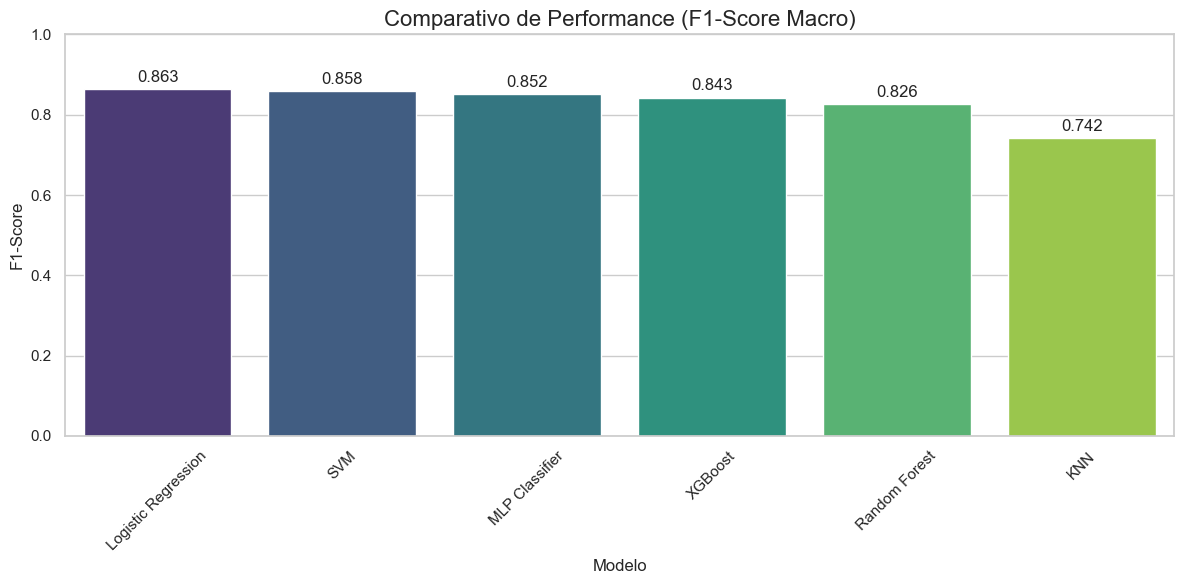

In [558]:
# ==============================================================================
# TREINAMENTO E AVALIAÇÃO COMPARATIVA (BENCHMARK)
# ==============================================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

modelos = {
    "XGBoost": XGBClassifier(
        random_state=42, 
        eval_metric='mlogloss', 
        n_jobs=-1
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1
    ),
    "Logistic Regression": LogisticRegression(
        max_iter=1000, 
        random_state=42
    ),
    "SVM": SVC(
        probability=True, 
        random_state=42
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=5, 
        n_jobs=-1
    ),
    "MLP Classifier": MLPClassifier(
        hidden_layer_sizes=(100, 50),
        max_iter=500,
        activation='relu',
        solver='adam',
        early_stopping=True,
        random_state=42
    )
}

resultados = []
print(f"🚀 Iniciando Benchmark com {len(modelos)} modelos...")

for nome, modelo in modelos.items():
    try:
        modelo.fit(X_train_bal, y_train_bal)
        
        y_pred = modelo.predict(X_test_scaled)
        y_probs = modelo.predict_proba(X_test_scaled)
        
        metrics = {
            "Modelo": nome,
            "Acurácia": accuracy_score(y_test, y_pred),
            "F1-Score (Macro)": f1_score(y_test, y_pred, average='macro'),
            "ROC AUC": roc_auc_score(y_test, y_probs, multi_class='ovr', average='macro'),
            "Precision": precision_score(y_test, y_pred, average='macro', zero_division=0),
            "Recall": recall_score(y_test, y_pred, average='macro')
        }
        resultados.append(metrics)
        print(f"✅ {nome:<20} | F1-Score: {metrics['F1-Score (Macro)']:.4f}")
        
    except Exception as e:
        print(f"❌ Erro ao treinar {nome}: {e}")

# ==============================================================================
# VISUALIZAÇÃO DOS RESULTADOS
# ==============================================================================

df_resultados = pd.DataFrame(resultados).set_index("Modelo")
df_resultados = df_resultados.sort_values(by="F1-Score (Macro)", ascending=False)

print("\n--- Ranking Final (Ordenado por F1-Score Macro) ---")
display(df_resultados)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=df_resultados.index, 
    y=df_resultados["F1-Score (Macro)"], 
    palette="viridis", 
    hue=df_resultados.index, 
    legend=False
)

plt.title("Comparativo de Performance (F1-Score Macro)", fontsize=16)
plt.ylabel("F1-Score")
plt.xlabel("Modelo")
plt.ylim(0, 1.0)
plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

In [559]:
# ==============================================================================
# OTIMIZAÇÃO DE HIPERPARÂMETROS (RANDOMIZED SEARCH)
# ==============================================================================

param_grids = {
    "Logistic Regression": {
        'C': np.logspace(-3, 3, 7),
        'solver': ['lbfgs', 'liblinear'],
        'penalty': ['l2'] 
    },
    "SVM": {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'poly']
    },
    "MLP Classifier": {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 50, 50)],
        'activation': ['tanh', 'relu'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01]
    },
    "XGBoost": {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
}

instancias_base = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    
    "MLP Classifier": MLPClassifier(max_iter=3000, random_state=42), 
    
    "XGBoost": XGBClassifier(
        objective='multi:softprob', 
        eval_metric='mlogloss', 
        use_label_encoder=False, 
        random_state=42
    )
}

print("⌛ Iniciando otimização com correção de convergência...")

modelos_para_testar = ["Logistic Regression", "SVM", "MLP Classifier", "XGBoost"]
modelos_otimizados = {}

for nome in modelos_para_testar:
    print(f"🔎 Otimizando {nome}...")
    
    search = RandomizedSearchCV(
        estimator=instancias_base[nome],
        param_distributions=param_grids[nome],
        n_iter=15, 
        cv=5, 
        scoring='f1_macro', 
        n_jobs=-1, 
        random_state=42
    )
    
    search.fit(X_train_bal, y_train_bal)
    modelos_otimizados[nome] = search.best_estimator_
    
    print(f"✅ Melhor F1-Score (Treino-CV) para {nome}: {search.best_score_:.4f}")
    print(f"📌 Melhores Parâmetros: {search.best_params_}\n")

print("--- Otimização Concluída! ---")

⌛ Iniciando otimização com correção de convergência...
🔎 Otimizando Logistic Regression...
✅ Melhor F1-Score (Treino-CV) para Logistic Regression: 0.8752
📌 Melhores Parâmetros: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 100.0}

🔎 Otimizando SVM...
✅ Melhor F1-Score (Treino-CV) para SVM: 0.9130
📌 Melhores Parâmetros: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}

🔎 Otimizando MLP Classifier...
✅ Melhor F1-Score (Treino-CV) para MLP Classifier: 0.9242
📌 Melhores Parâmetros: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (100,), 'alpha': 0.01, 'activation': 'relu'}

🔎 Otimizando XGBoost...
✅ Melhor F1-Score (Treino-CV) para XGBoost: 0.9128
📌 Melhores Parâmetros: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2}

--- Otimização Concluída! ---


🔄 Retreinando o modelo campeão com todo o conjunto de treino balanceado...

--- RELATÓRIO DE CLASSIFICAÇÃO (TESTE) ---
              precision    recall  f1-score   support

 Quartzo (0)       0.86      0.87      0.87        63
   Ágata (1)       0.83      0.84      0.83       144
Ametista (2)       0.89      0.83      0.86       224
 Topázio (3)       0.86      0.93      0.90       138

    accuracy                           0.86       569
   macro avg       0.86      0.87      0.86       569
weighted avg       0.86      0.86      0.86       569



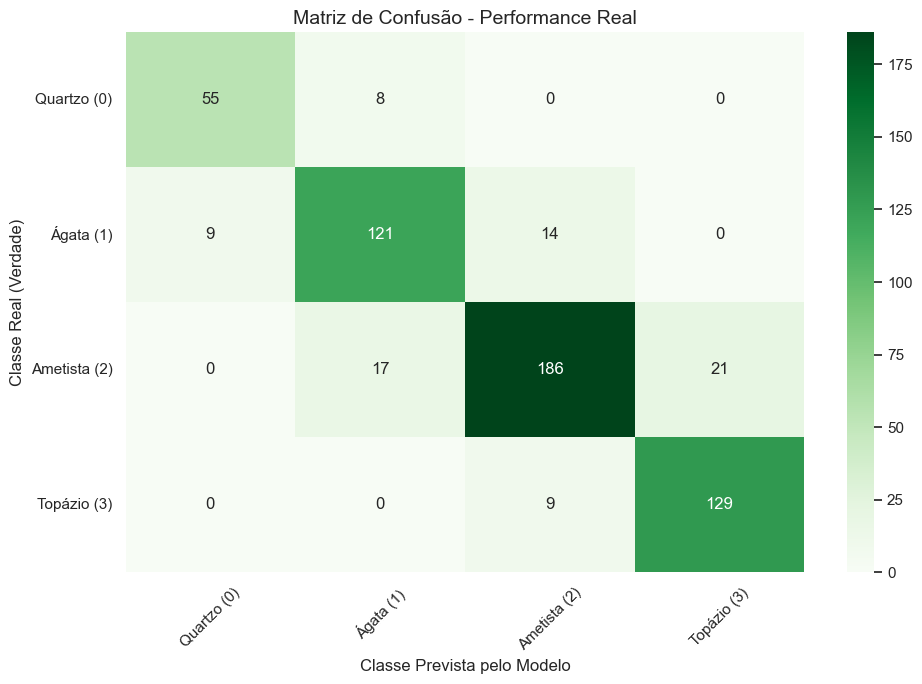

In [560]:
# ==============================================================================
# TREINAMENTO FINAL E VALIDAÇÃO DO MODELO CAMPEÃO
# ==============================================================================

best_params = {
    'hidden_layer_sizes': (100,),
    'activation': 'relu',
    'alpha': 0.01,
    'learning_rate_init': 0.001,
    'max_iter': 2000,
    'random_state': 42
}

print("🔄 Retreinando o modelo campeão com todo o conjunto de treino balanceado...")
final_model = MLPClassifier(**best_params)

final_model.fit(X_train_bal, y_train_bal)

y_pred_final = final_model.predict(X_test_scaled)

classes_nomes = ['Quartzo (0)', 'Ágata (1)', 'Ametista (2)', 'Topázio (3)']

print("\n--- RELATÓRIO DE CLASSIFICAÇÃO (TESTE) ---")
print(classification_report(y_test, y_pred_final, target_names=classes_nomes))

plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred_final)

sns.heatmap(
    cm, 
    annot=True, 
    fmt='d',
    cmap='Greens',
    xticklabels=classes_nomes,
    yticklabels=classes_nomes
)

plt.title('Matriz de Confusão - Performance Real', fontsize=14)
plt.ylabel('Classe Real (Verdade)', fontsize=12)
plt.xlabel('Classe Prevista pelo Modelo', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()